In [360]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme()

In [361]:
from sklearn.linear_model import LogisticRegression

from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

## Preparando Dados

In [362]:
enem = pd.read_csv('../src/enem_total_dum.csv')

enem.set_index('NU_INSCRICAO', drop=True, inplace=True)

enem.head()

,APPROVED_ADM,APPROVED_MED,TP_SEXO_M,TP_COR_RACA_1,TP_COR_RACA_2,TP_COR_RACA_3,TP_COR_RACA_4,TP_COR_RACA_5,TP_ESTADO_CIVIL_1,TP_ESTADO_CIVIL_2,...,Q006_P,Q006_Q,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q005,NU_NOTA_MEDIA
NU_INSCRICAO,,,,,,,,,,,,,,,,,,,,,
190003903183,0,0,0,0,0,1,0,0,1,0,...,0,0,19,437.9,423.7,457.2,461.9,0.0,5,445.175
190005124618,0,0,0,0,1,0,0,0,1,0,...,0,0,19,426.2,548.7,537.9,427.7,600.0,4,485.125
190001447215,0,0,0,0,0,1,0,0,0,1,...,0,0,39,471.0,512.2,527.3,501.5,580.0,3,503.000
190003825026,0,0,1,0,0,1,0,0,1,0,...,0,0,17,359.3,520.1,430.1,493.3,440.0,4,450.700
190001995539,0,0,0,1,0,0,0,0,1,0,...,0,0,17,494.7,503.7,545.2,585.6,880.0,5,532.300


In [363]:
enem.shape

(10000, 86)

In [364]:
def plot_roc_curve(texto, y_true, y_score, figsize=(10,6)):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    plt.figure(figsize = figsize)
    auc_value = roc_auc_score(y_true, y_score)
    plt.plot(fpr, tpr, color = 'orange', label = 'ROC CURVE (area = %0.2f)' % auc_value)
    plt.plot([0,1], [0,1], color = 'darkblue', linestyle = '--')
    plt.xlabel('Especificidade')
    plt.ylabel('Sensibilidade')
    plt.title('Curva ROC {}'.format(texto))
    plt.legend()

    text = '../img/curva_roc_{}.png'.format(texto)
    plt.savefig(text,  bbox_inches='tight')
    plt.show()

In [365]:
def plot_confusion(texto, modelo, x, y, figsize=(10,6)):
    fig, ax = plt.subplots(figsize=figsize)
    plt.rcParams.update({'font.size': 16})
    plot_confusion_matrix(modelo, x, y, cmap='Blues', ax = ax)
    plt.xlabel('Previsto', fontsize=18)
    plt.ylabel('Real', fontsize=18)
    plt.title('Matriz de Confusão {}'.format(texto), fontsize=18)

    text = '../img/confusion_{}.png'.format(texto)
    plt.savefig(text,  bbox_inches='tight')
    plt.show()

In [366]:
X = enem.drop(['APPROVED_ADM', 'APPROVED_MED'], axis=1)
y = enem['APPROVED_ADM']

In [367]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)

## Primeiro Modelo Logístico

In [368]:
model = LogisticRegression()

In [369]:
y.value_counts()

0    8467
1    1533
Name: APPROVED_ADM, dtype: int64

In [370]:
model_fit = model.fit(X_train, y_train)

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [371]:
yhat_train = model.predict_proba(X_train)
yhat_train = yhat_train[:, 1]

In [372]:
yhat_train

array([0.10865729, 0.96893042, 0.01868364, ..., 0.02005771, 0.66504668,
       0.0060698 ])

In [373]:
yhat_test = model.predict_proba(X_test)
yhat_test = yhat_test[:, 1]

In [374]:
matrix = confusion_matrix(y_train, model.predict(X_train))

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


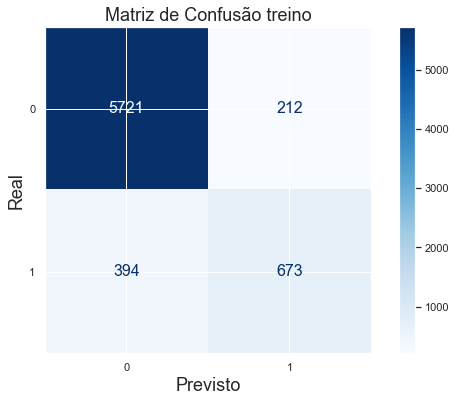

In [375]:
plot_confusion('treino', model, X_train, y_train)

In [376]:
print(classification_report(y_train, model.predict(X_train)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5933
           1       0.76      0.63      0.69      1067

    accuracy                           0.91      7000
   macro avg       0.85      0.80      0.82      7000
weighted avg       0.91      0.91      0.91      7000



In [377]:
print('AUC: %0.5f' % roc_auc_score(y_train, yhat_train))

AUC: 0.91172


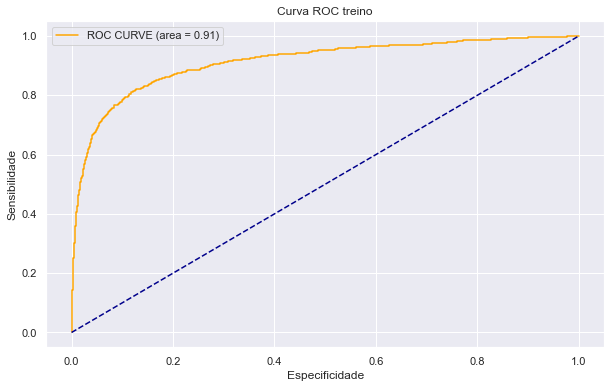

In [378]:
plot_roc_curve('treino', y_train, yhat_train)

In [379]:
matrix = confusion_matrix(y_test, model.predict(X_test))

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


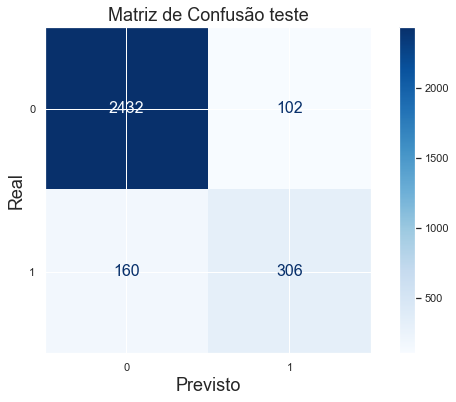

In [380]:
plot_confusion('teste', model, X_test, y_test)

In [381]:
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2534
           1       0.75      0.66      0.70       466

    accuracy                           0.91      3000
   macro avg       0.84      0.81      0.82      3000
weighted avg       0.91      0.91      0.91      3000



In [382]:
print('AUC: %0.5f' % roc_auc_score(y_test, yhat_test))

AUC: 0.92834


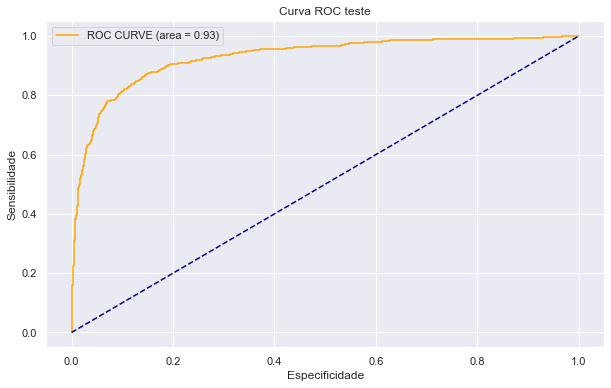

In [383]:
plot_roc_curve('teste', y_test, yhat_test)

## Previsão

### Dataframe Previsão Padrão

In [384]:
default_prevision = pd.DataFrame(
    [
        {
        'TP_SEXO_M': 0, 
        'TP_COR_RACA_1': 0, 
        'TP_COR_RACA_2': 0, 
        'TP_COR_RACA_3': 0,
        'TP_COR_RACA_4': 0, 
        'TP_COR_RACA_5': 0, 
        'TP_ESTADO_CIVIL_1': 0,
        'TP_ESTADO_CIVIL_2': 0, 
        'TP_ESTADO_CIVIL_3': 0, 
        'TP_ESTADO_CIVIL_4': 0,
        'SG_UF_RESIDENCIA_AL': 0, 
        'SG_UF_RESIDENCIA_AM': 0, 
        'SG_UF_RESIDENCIA_AP': 0,
        'SG_UF_RESIDENCIA_BA': 0, 
        'SG_UF_RESIDENCIA_CE': 0, 
        'SG_UF_RESIDENCIA_DF': 0,
        'SG_UF_RESIDENCIA_ES': 0, 
        'SG_UF_RESIDENCIA_GO': 0, 
        'SG_UF_RESIDENCIA_MA': 0,
        'SG_UF_RESIDENCIA_MG': 0, 
        'SG_UF_RESIDENCIA_MS': 0, 
        'SG_UF_RESIDENCIA_MT': 0,
        'SG_UF_RESIDENCIA_PA': 0, 
        'SG_UF_RESIDENCIA_PB': 0, 
        'SG_UF_RESIDENCIA_PE': 0,
        'SG_UF_RESIDENCIA_PI': 0, 
        'SG_UF_RESIDENCIA_PR': 0, 
        'SG_UF_RESIDENCIA_RJ': 0,
        'SG_UF_RESIDENCIA_RN': 0, 
        'SG_UF_RESIDENCIA_RO': 0, 
        'SG_UF_RESIDENCIA_RR': 0,
        'SG_UF_RESIDENCIA_RS': 0, 
        'SG_UF_RESIDENCIA_SC': 0, 
        'SG_UF_RESIDENCIA_SE': 0,
        'SG_UF_RESIDENCIA_SP': 0, 
        'SG_UF_RESIDENCIA_TO': 0, 
        'Q001_B': 0, 
        'Q001_C': 0,
        'Q001_D': 0, 
        'Q001_E': 0, 
        'Q001_F': 0, 
        'Q001_G': 0, 
        'Q001_H': 0, 
        'Q002_B': 0, 
        'Q002_C': 0,
        'Q002_D': 0, 
        'Q002_E': 0, 
        'Q002_F': 0, 
        'Q002_G': 0, 
        'Q002_H': 0, 
        'Q003_B': 0, 
        'Q003_C': 0,
        'Q003_D': 0, 
        'Q003_E': 0, 
        'Q003_F': 0, 
        'Q004_B': 0, 
        'Q004_C': 0, 
        'Q004_D': 0, 
        'Q004_E': 0,
        'Q004_F': 0, 
        'Q006_B': 0, 
        'Q006_C': 0, 
        'Q006_D': 0, 
        'Q006_E': 0, 
        'Q006_F': 0, 
        'Q006_G': 0,
        'Q006_H': 0, 
        'Q006_I': 0, 
        'Q006_J': 0, 
        'Q006_K': 0, 
        'Q006_L': 0, 
        'Q006_M': 0, 
        'Q006_N': 0,
        'Q006_O': 0, 
        'Q006_P': 0, 
        'Q006_Q': 0, 
        'NU_IDADE': 0, 
        'NU_NOTA_CN': 0, 
        'NU_NOTA_CH': 0,
        'NU_NOTA_LC': 0, 
        'NU_NOTA_MT': 0, 
        'NU_NOTA_REDACAO': 0, 
        'Q005': 0, 
        'NU_NOTA_MEDIA': 0
}])

In [385]:
columns = ['TP_SEXO_M', 'TP_COR_RACA_1', 'TP_COR_RACA_2', 'TP_COR_RACA_3',
       'TP_COR_RACA_4', 'TP_COR_RACA_5', 'TP_ESTADO_CIVIL_1',
       'TP_ESTADO_CIVIL_2', 'TP_ESTADO_CIVIL_3', 'TP_ESTADO_CIVIL_4',
       'SG_UF_RESIDENCIA_AL', 'SG_UF_RESIDENCIA_AM', 'SG_UF_RESIDENCIA_AP',
       'SG_UF_RESIDENCIA_BA', 'SG_UF_RESIDENCIA_CE', 'SG_UF_RESIDENCIA_DF',
       'SG_UF_RESIDENCIA_ES', 'SG_UF_RESIDENCIA_GO', 'SG_UF_RESIDENCIA_MA',
       'SG_UF_RESIDENCIA_MG', 'SG_UF_RESIDENCIA_MS', 'SG_UF_RESIDENCIA_MT',
       'SG_UF_RESIDENCIA_PA', 'SG_UF_RESIDENCIA_PB', 'SG_UF_RESIDENCIA_PE',
       'SG_UF_RESIDENCIA_PI', 'SG_UF_RESIDENCIA_PR', 'SG_UF_RESIDENCIA_RJ',
       'SG_UF_RESIDENCIA_RN', 'SG_UF_RESIDENCIA_RO', 'SG_UF_RESIDENCIA_RR',
       'SG_UF_RESIDENCIA_RS', 'SG_UF_RESIDENCIA_SC', 'SG_UF_RESIDENCIA_SE',
       'SG_UF_RESIDENCIA_SP', 'SG_UF_RESIDENCIA_TO', 'Q001_B', 'Q001_C',
       'Q001_D', 'Q001_E', 'Q001_F', 'Q001_G', 'Q001_H', 'Q002_B', 'Q002_C',
       'Q002_D', 'Q002_E', 'Q002_F', 'Q002_G', 'Q002_H', 'Q003_B', 'Q003_C',
       'Q003_D', 'Q003_E', 'Q003_F', 'Q004_B', 'Q004_C', 'Q004_D', 'Q004_E',
       'Q004_F', 'Q006_B', 'Q006_C', 'Q006_D', 'Q006_E', 'Q006_F', 'Q006_G',
       'Q006_H', 'Q006_I', 'Q006_J', 'Q006_K', 'Q006_L', 'Q006_M', 'Q006_N',
       'Q006_O', 'Q006_P', 'Q006_Q', 'NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH',
       'NU_NOTA_LC', 'NU_NOTA_MT', 'NU_NOTA_REDACAO', 'Q005', 'NU_NOTA_MEDIA']

values = [
    0, 0, 1, 0,
    0, 0, 0, 
    1, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    0, 0, 0,
    1, 0, 0, 0,
    0, 1, 0, 0, 0, 0, 1,
    0, 0, 0, 0, 0, 0, 1,
    0, 0, 0, 1, 0, 0, 0,
    0, 0, 0, 0, 0, 0, 0,
    1, 0, 0, 0, 0, 0, 0,
    0, 0, 0, 20, 800, 800,
    800, 800, 800, 5, 800
]

df = pd.DataFrame([values], columns = columns)

#df['column'] = columns
#df['value'] = values

### Analises Diferentes

Analise 1 - Qual a porcentagem de chance de um Estudante do sexo Masculino, Branco, Solteiro, morador do Estado de São Paulo, com 18 anos, notas em torno de 700, 3 pessoas morando na casa e uma renda maior que 19000 passar no ENEM?

In [386]:
previsao1 = default_prevision.copy()

previsao1.TP_SEXO_M = 1
previsao1.TP_COR_RACA_1 = 1
previsao1.TP_ESTADO_CIVIL_1 = 1
previsao1.SG_UF_RESIDENCIA_SP = 1
previsao1.Q001_G = 1
previsao1.Q002_G = 1
previsao1.Q006_Q = 1
previsao1.NU_IDADE = 18
previsao1.NU_NOTA_CN = 700
previsao1.NU_NOTA_CH = 700
previsao1.NU_NOTA_LC = 700
previsao1.NU_NOTA_MT = 700
previsao1.NU_NOTA_REDACAO = 700
previsao1.Q005 = 3
previsao1.NU_NOTA_MEDIA = 700

yhat_prev = model.predict_proba(previsao1)

print('Ele teria {}% de probabilidade de passar no ENEM'\
      .format(round(yhat_prev[:,1][0]*100, 2)))

Ele teria 77.81% de probabilidade de passar no ENEM


Analise 2 - E um homem negro nas mesmas condições anteriores?

In [387]:
previsao2 = default_prevision.copy()

previsao2.TP_SEXO_M = 1
previsao2.TP_COR_RACA_2 = 1
previsao2.TP_ESTADO_CIVIL_1 = 1
previsao2.SG_UF_RESIDENCIA_SP = 1
previsao2.Q001_G = 1
previsao2.Q002_G = 1
previsao2.Q006_Q = 1
previsao2.NU_IDADE = 18
previsao2.NU_NOTA_CN = 700
previsao2.NU_NOTA_CH = 700
previsao2.NU_NOTA_LC = 700
previsao2.NU_NOTA_MT = 700
previsao2.NU_NOTA_REDACAO = 700
previsao2.Q005 = 3
previsao2.NU_NOTA_MEDIA = 700

yhat_prev = model.predict_proba(previsao2)

print('Ele teria {}% de probabilidade de passar no ENEM'\
      .format(round(yhat_prev[:,1][0]*100, 2)))

Ele teria 75.82% de probabilidade de passar no ENEM


Analise 3 - E uma mulher negra nas mesmas condições anteriores?

In [388]:
previsao3 = default_prevision.copy()

previsao3.TP_COR_RACA_2 = 1
previsao3.TP_ESTADO_CIVIL_1 = 1
previsao3.SG_UF_RESIDENCIA_SP = 1
previsao3.Q001_G = 1
previsao3.Q002_G = 1
previsao3.Q006_Q = 1
previsao3.NU_IDADE = 18
previsao3.NU_NOTA_CN = 700
previsao3.NU_NOTA_CH = 700
previsao3.NU_NOTA_LC = 700
previsao3.NU_NOTA_MT = 700
previsao3.NU_NOTA_REDACAO = 700
previsao3.Q005 = 3
previsao3.NU_NOTA_MEDIA = 700

yhat_prev = model.predict_proba(previsao3)

print('Ele teria {}% de probabilidade de passar no ENEM'\
      .format(round(yhat_prev[:,1][0]*100, 2)))

Ele teria 76.45% de probabilidade de passar no ENEM


### Mas as condições realmente são iguai?

In [389]:
enem_total = pd.read_csv('../src/enem_total.csv')

In [390]:
enem_total.head()

,NU_INSCRICAO,NU_ANO,TP_SEXO,TP_COR_RACA,TP_ESTADO_CIVIL,TP_NACIONALIDADE,SG_UF_RESIDENCIA,TP_ST_CONCLUSAO,Q001,Q002,...,NU_IDADE,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,Q005,NU_NOTA_MEDIA,APPROVED_ADM,APPROVED_MED
0,190003903183,2019,F,3,1,1,SE,2,B,B,...,19,437.9,423.7,457.2,461.9,0.0,5,445.175,0,0
1,190005124618,2019,F,2,1,1,SP,2,A,A,...,19,426.2,548.7,537.9,427.7,600.0,4,485.125,0,0
2,190001447215,2019,F,3,2,1,BA,1,B,C,...,39,471.0,512.2,527.3,501.5,580.0,3,503.000,0,0
3,190003825026,2019,M,3,1,1,MT,2,E,E,...,17,359.3,520.1,430.1,493.3,440.0,4,450.700,0,0
4,190001995539,2019,F,1,1,1,MA,2,B,E,...,17,494.7,503.7,545.2,585.6,880.0,5,532.300,0,0


In [391]:
enem_total_notal = enem_total[['NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'TP_COR_RACA', 'NU_NOTA_REDACAO', 'NU_NOTA_MEDIA']]
enem_total_notal.groupby(by='TP_COR_RACA').mean()

,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,NU_NOTA_REDACAO,NU_NOTA_MEDIA
TP_COR_RACA,,,,,,
0,477.840625,513.388021,527.811979,532.494271,567.812500,512.883724
1,492.637255,527.416736,538.241342,543.626263,605.672466,525.480399
2,464.235155,496.934992,514.796330,494.586623,553.376835,492.638275
3,467.497726,498.826963,513.805663,503.910639,563.547834,496.010248
4,478.181933,510.144538,527.249160,525.423109,593.277311,510.249685
5,457.408197,479.150820,495.101639,506.468852,529.180328,484.532377


<AxesSubplot:xlabel='Q006'>

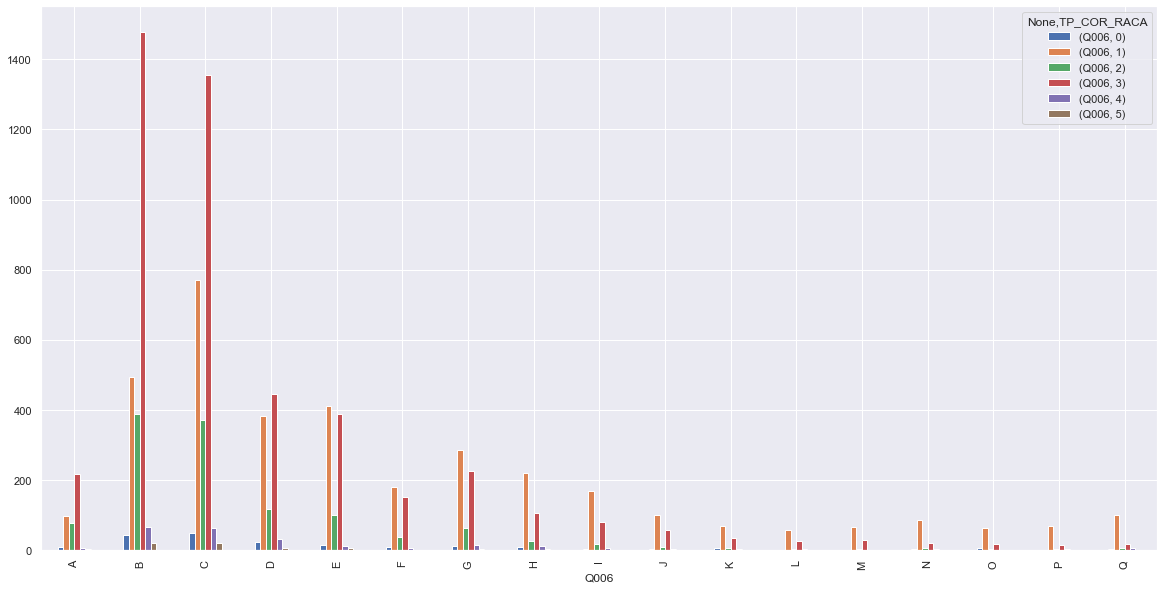

In [392]:
enem_total.groupby(by='TP_COR_RACA').agg({'Q006': 'value_counts'}).unstack(0).plot(kind='bar', figsize=(20,10))

Com as análises acima, consegue-se ver que:

    - Para as estudantes das Raças Preta (2) e Parda (3) as Médias das Notas são menores em comparação com estudantes da Raça Branca (1).
    - No gráfico acima, temos o agrupamento das Raças em relação a Faixa de Renda das Famílias e tem-se:
        Uma quantidade muito maior concentrada nas Faixas de Renda mais baixas da soma das Raças Preta e Parda em comparação com as outras. 
        E nas maiores faixas quase nenhuma representação.
        É nítido no gráfico que na Faixa A predomina Raça Parda, assim como na B, C e D.
        A partir da Faixa E começa a inverter e a Raça Branca começa a dominar, não na mesma proporção, mas isso pode fazer a média de renda da Raça Branca ser maior que a Parda, que está concentrada nas Faixas mais baixas.

### Mais uma Análise

Com base no que foi visto, propõe-se uma nova previsão mais realista do que os Dados informaram

Pretas e Pardas - NOTA média CN 467.497726 CH 498.826963 LC 513.805663 MT 503.910639 REDACAO 563.547834 MEDIA 496.010248
                    Renda - B

Brancas - NOTAM média CN 492.637255 CH 527.416736 LC 538.241342	MT 543.626263 REDACAO 605.672466	MEDIA 525.480399
                    Renda - G

In [393]:
previsao4 = default_prevision.copy()

previsao4.TP_SEXO_M = 1
previsao4.TP_COR_RACA_1 = 1
previsao4.TP_ESTADO_CIVIL_1 = 1
previsao4.SG_UF_RESIDENCIA_SP = 1
previsao4.Q001_G = 1
previsao4.Q002_G = 1
previsao4.Q006_G = 1
previsao4.NU_IDADE = 18
previsao4.NU_NOTA_CN = 492
previsao4.NU_NOTA_CH = 527
previsao4.NU_NOTA_LC = 538
previsao4.NU_NOTA_MT = 543
previsao4.NU_NOTA_REDACAO = 605
previsao4.Q005 = 3
previsao4.NU_NOTA_MEDIA = 525

yhat_prev = model.predict_proba(previsao4)

print('Ele teria {}% de probabilidade de passar no ENEM'\
      .format(round(yhat_prev[:,1][0]*100, 2)))

Ele teria 30.08% de probabilidade de passar no ENEM


In [394]:
previsao5 = default_prevision.copy()

previsao5.TP_SEXO_M = 1
previsao5.TP_COR_RACA_1 = 1
previsao5.TP_ESTADO_CIVIL_1 = 1
previsao5.SG_UF_RESIDENCIA_SP = 1
previsao5.Q001_G = 1
previsao5.Q002_G = 1
previsao5.Q006_B = 1
previsao5.NU_IDADE = 18
previsao5.NU_NOTA_CN = 467
previsao5.NU_NOTA_CH = 498
previsao5.NU_NOTA_LC = 513
previsao5.NU_NOTA_MT = 503
previsao5.NU_NOTA_REDACAO = 563
previsao5.Q005 = 3
previsao5.NU_NOTA_MEDIA = 496

yhat_prev = model.predict_proba(previsao5)

print('Ele teria {}% de probabilidade de passar no ENEM'\
      .format(round(yhat_prev[:,1][0]*100, 2)))

Ele teria 16.62% de probabilidade de passar no ENEM


## Segundo Modelo Logístico com Validação Cruzada

In [395]:
test_size = 0.20
np.random.seed(7)
scoring = 'accuracy'
num_folds = 10
solver = 'newton-cg'

In [396]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size)

In [397]:
model = LogisticRegression(solver = solver)

In [398]:
kfold = KFold(n_splits = num_folds)

In [399]:
cv_result = cross_val_score(model, X_train, y_train, cv = kfold, scoring = scoring)

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the numb

In [400]:
cv_result

array([0.995  , 0.99125, 0.9925 , 0.99625, 0.9925 , 0.99   , 0.99   ,
       0.99   , 0.9925 , 0.9925 ])

In [401]:
print('%s: %0.5f(%0.4f)' % ('Regressão Logística', cv_result.mean(), cv_result.std()))

Regressão Logística: 0.99225(0.0020)


## Ajuste dos Hiperparâmetros do Modelo Logístico

## Comparação entre Modelos de Classificação

In [402]:
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.preprocessing import StandardScaler

In [403]:
models = []

In [404]:
models.append(('LR', LogisticRegression(solver='newton-cg')))

In [405]:
models.append(('KNN', KNeighborsClassifier()))

In [406]:
models.append(('CART', DecisionTreeClassifier()))

In [407]:
models.append(('NB', GaussianNB()))

In [408]:
models.append(('SVM', SVC()))

In [409]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = '%s: %f (%f)' % (name, cv_results.mean(), cv_results.std())
    print(msg)

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  warnings.warn(
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\utils\optimize.py:210: ConvergenceWarning: newton-cg failed to converge. Increase the numb

LR: 0.992250 (0.002000)
KNN: 0.987625 (0.003810)
CART: 0.999875 (0.000375)
NB: 0.888375 (0.010171)
SVM: 0.991000 (0.002151)


## Método da Máxima Verossimilhança

In [410]:
model.classes_

AttributeError: 'SVC' object has no attribute 'classes_'

In [ ]:
model.intercept_

array([-21.07417003])

In [ ]:
model.coef_

array([[ 0.00000000e+00, -2.10619664e-03,  0.00000000e+00, ...,
         2.20322086e-01,  1.36162989e-01,  5.22376168e+00]])

In [ ]:
log_likelihood_elements = y*np.log(yhat) + (1-y)*np.log(1-yhat)
log_likelihood_elements

NU_INSCRICAO
190003903183    0.000000e+00
190005124618   -1.174616e-13
190001447215   -4.192480e-10
190003825026    0.000000e+00
190001995539   -2.628550e-06
                    ...     
190005285745    0.000000e+00
190001247842   -3.713141e-11
190003996202   -1.665446e-12
190002228082   -9.436896e-15
190002234389    0.000000e+00
Name: APPROVED_ADM, Length: 10000, dtype: float64

In [ ]:
-np.sum(log_likelihood_elements)/len(y)
# 0.60671964791658428

log_loss(y, yhat) == -np.sum(log_likelihood_elements)/len(y)

NameError: name 'log_loss' is not defined

## Modelo Logistico com Stats Model

In [ ]:
import statsmodels.api as sm

In [ ]:
model = sm.Logit(y, X)

In [ ]:
corr = np.corrcoef(X.values, rowvar=False)
sns.heatmap(corr, annot=True, cmap='Blues', fmt='.2f', cbar=False, xticklabels=X.columns, yticklabels=X.columns)

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\numpy\lib\function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


In [ ]:
result = model.fit(method='newton')

C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1819: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
C:\Users\DESKTOP\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\discrete\discrete_model.py:1872: RuntimeWarning: divide by zero encountered in log
  return np.sum(np.log(self.cdf(q*np.dot(X,params))))


         Current function value: inf
         Iterations: 35


LinAlgError: Singular matrix

In [ ]:
result.params

In [ ]:
result.summary()